In [1]:
%matplotlib inline
#%qtconsole

import os
import cPickle
import numpy as np
import pandas
from scipy import linalg

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.figure import Figure
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.basemap import Basemap

from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta
from scipy import stats
import numpy as np
import os.path
import string


In [2]:
def cts_sampler(y,t,binStarts,binEnds):
    ''' A sampling function that takes a time series and subsamples with bin center indices binc and bin widths binw. Both can be non-integer. If the bin is out of range at time series edges, values are ignored. Time must be monotonically increasing.'''

    # Make a sorted vector of all times (bin and record)
    allt = np.unique(np.concatenate([t,binStarts,binEnds],0))

    # Interpolate to all times
    yint = np.interp(allt,t,y)
    
    # Initialize binMeans
    binMeans = np.nan*np.ones(len(binStarts));

    # Proceed by each pair of bin starts and ends.
    for ii in np.arange(0,len(binStarts)):
        bs = binStarts[ii]
        be = binEnds[ii]
        
#        import pdb
#        pdb.set_trace()

        # Store all times between (and including) bs and be
        theseT = allt[(allt>=bs) & (allt<=be)]
        # Store the interpolated record subset spanning these times
        subRec = yint[(allt>=bs) & (allt<=be)]
        # Integrate the continuous piecewise-linear function created by linearly interpolating between observations
        binMeans[ii] = np.dot(np.diff(theseT),.5*(subRec[:-1]+subRec[1:]))/np.sum(np.diff(theseT))

    # Make the vector of bin centers (times associated with averages)
    binCenters = np.average(np.array([binStarts,binEnds]),0)
    return binMeans, binCenters
    
    

In [3]:
def cts_sampler2(y,t,binStarts,binEnds):
    ''' Make this one just a simple average over whatever points fall between binStarts and binEnds.'''
    # Make a sorted vector of all times (bin and record)
    allt = np.unique(np.concatenate([t,binStarts,binEnds],0))

    # Interpolate to all times
    yint = np.interp(allt,t,y)
    
    # Initialize binMeans
    binMeans = np.nan*np.ones(len(binStarts));

    # Proceed by each pair of bin starts and ends.
    for ii in np.arange(0,len(binStarts)):
        bs = binStarts[ii]
        be = binEnds[ii]
        
#        import pdb
#        pdb.set_trace()

        # Store all times between bs and be
        theseT = allt[(allt>bs) & (allt<be)]
        # Store the interpolated record subset spanning these times
        subRec = yint[(allt>bs) & (allt<be)]
        # Integrate the continuous piecewise-linear function created by linearly interpolating between observations
        binMeans[ii] = np.mean(subRec)

    # Make the vector of bin centers (times associated with averages)
    binCenters = np.average(np.array([binStarts,binEnds]),0)
    return binMeans, binCenters
    
    

In [4]:
'''
Generate Dicrete Colored Noise
python / numpy implementation of 
Kasdin, N.J., Walter, T., "Discrete simulation of power law noise 
[for oscillator stability evaluation]," 
Frequency Control Symposium, 1992. 46th., Proceedings of the 1992 IEEE, 
pp.274,283, 27-29 May 1992
http://dx.doi.org/10.1109/FREQ.1992.270003
'''

# author: Julia Leute
# https://github.com/jleute/colorednoise/blob/master/colorednoise.py

import numpy as np

def noiseGen(nr, Qd, b):

    ''' Generates discrete colored noise
    required inputs: 
        nr (number of points, must be power of two)
        Qd (discrete variance)
        b (slope of the noise) '''

    mhb = -b/2.0
    Qd = np.sqrt(Qd)
    # fill sequence wfb with white noise
    wfb = np.zeros(nr*2)
    wfb[:nr] = np.random.normal(0, Qd, nr)
    # generate the coefficients hfb
    hfb = np.zeros(nr*2)    
    hfb[0] = 1.0
    indices = np.arange(nr-1)
    hfb[1:nr] = (mhb+indices)/(indices+1.0)
    hfb[:nr] = np.multiply.accumulate(hfb[:nr])
    # discrete Fourier transforms of white noise and coefficients,
    # multiplication of resulting complex vectors, 
    # inverse Fourier transform
    colorednoise = np.fft.irfft(np.fft.rfft(wfb)*np.fft.rfft(hfb))[:nr]
    return colorednoise

In [5]:
''' Function to plot time series and spectra of subsampled power law noise.
    Required inputs:
    RL (number of years, must be power of two)
    beta (negative slope of the noise)
    taus (sample rate, years, double)
    taub (sample duration, years, double)
    ffname (figure file name, str)
'''

import pandas as pd
def plot_noise(RL,beta,taus,taub,ffname):

    # Lowest position of frequency to start showing on plots
    FS = 3

    # Number of points to include within individual years
    NIY = 2**0

    # Number of points in the record
    L = RL*NIY

    # Generate the synthetic noise time series wd
    wd = noiseGen(L,1,-beta)

    # Time
    wt = np.linspace(-RL+1,0,num=L)

    # bin centers spaced at sr
    bc = np.arange(-RL,-taus,taus)

    # Subsample the record using dense sampling
    binStarts = bc-taus/2
    binEnds = bc+taus/2
    den, fden = cts_sampler(wd,wt,binStarts,binEnds)

    # Discontinuous sampling 1
    binStarts = bc-taub/2
    binEnds = bc+taub/2
    dis, fdis = cts_sampler(wd,wt,binStarts,binEnds)

    fig2 = plt.figure(figsize=(6,8))
    ax1 = fig2.add_subplot(3, 1, 1)
    ax1.plot(wt,wd, color='white')
    ax1.plot(fdis,dis, color='red')
    ax1.plot(fden,den, color='black')
    ax1.set_xlim(np.min(wt),np.max(wt))
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Measured variable")
    #ax1.legend([r'$\beta=$'+str(beta)])
#    ax1.legend(['Raw',r'$\tau_b$='+str(int(taus)),r'$\tau_b$='+str(int(taub))],bbox_to_anchor=(-.15, -.08, 1.5, .102))

    reload(matplotlib.pyplot)

    from mtspec import mtspec
    from mtspec.util import _load_mtdata

    spec, freq,jackknife,_,_= mtspec(wd,
                                     delta=np.median(np.diff(wt)), time_bandwidth=3,statistics=True)
    specDEN, freqDEN,jackknife2,_,_= mtspec(data=den,
                                     delta=taus, time_bandwidth=3,statistics=True)
    specDIS, freqDIS,jackknife3,_,_= mtspec(data=dis,
                                     delta=taus, time_bandwidth=3,statistics=True)

    # remove 0 frequency for plotting
    ax2 = fig2.add_subplot(3, 1, 2)

    ax2.plot(freq[FS:], spec[FS:], color='white')
    ax2.fill_between(freq[FS:], jackknife[FS:, 0], jackknife[FS:, 1],
                     color="white", alpha=0.4)
    ax2.plot(freqDIS[FS:], specDIS[FS:], color='red')
    ax2.plot(freqDEN[FS:], specDEN[FS:], color='black')
    ax2.set_xlabel("Frequency [yr$^{-1}]$")
    ax2.set_ylabel("Power Spectral Density")
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_xlim(min(freq[FS:]), 1E-2)
    #ax2.set_ylim(min(spec[1:]),max(spec[1:]))
    #ax2.legend(['Raw',r'$\tau_b$='+str(int(taus)),r'$\tau_b$='+str(int(taub))],bbox_to_anchor=(0, 0),mode='expand')
    #ax2.legend([r'$\beta=$'+str(beta)])

    plt.tight_layout()
    fig2.savefig(ffname, bbox_inches='tight')

    print('Ratio from variances = '+ str(np.var(den-dis)/np.var(dis)))


In [6]:
''' Function to return histograms of misfits between subsampled power law noise
    Required inputs:
    RL     (number of years, must be power of two)
    beta   (negative slope of the noise)
    taus   (sample rate, years, double)
    taub  (sample duration, years, double)
    N      (noise realization ensemble size)
'''

def noise_hist(RL,beta,taus,taub,N):

    # Record length in years

    # Number of points to include within individual years
    NIY = 2**0

    # Number of points in the record
    L = RL*NIY

    # Time
    wt = np.linspace(-RL,0,num=L)

    # bin centers spaced at taus
    bc = np.arange(-RL,-taus,taus)

    rvar = np.nan*np.ones(N)

    for ii in np.arange(N):

        wd = noiseGen(L,1,-beta)
        #wdl = noiseGen(16*L,1,-beta)
        #wd = wdl[8*L:9*L]

        # Subsample the record using dense sampling
        binStarts = bc-taus/2
        binEnds = bc+taus/2
        den, fden = cts_sampler2(wd,wt,binStarts,binEnds)

        # Discontinuous sampling 1
        binStarts = bc-taub/2
        binEnds = bc+taub/2
        dis, fdis = cts_sampler2(wd,wt,binStarts,binEnds)

        rvar[ii] =  np.var(den-dis)/np.var(dis)
        #rvar2[ii] = np.sqrt(np.mean((den-dis)**2))/np.sqrt(np.mean((dis)**2))

    print('Mean = '+str(np.mean(rvar)))
    print('Std = '+str(np.std(rvar)))

    return rvar


In [7]:
# Plotting function for noise histograms

def plot_hists(RL,beta,taus,taub1,taub2,N):

    rvar1 = noise_hist(RL,beta,taus,taub1,N)
    rvar2 = noise_hist(RL,beta,taus,taub2,N)

    fig5 = plt.figure()
    ax1 = fig5.add_subplot(2,1,1)
    ax1.hist(rvar1,alpha=0.5,bins=np.arange(0,1,.025))
    ax1.hist(rvar2,alpha=0.5,bins=np.arange(0,1,.025))
    ax1.legend([r'$\tau_s=200, \tau_d='+str(taub1)+'$',r'$\tau_s=200, \tau_d='+str(taub2)+'$'],frameon=False)
    ax1.set_ylabel("Frequency")
    ax1.set_xlabel("Variance due to discontinuous sampling \n as a fraction of total variance")
    ax1.text(0.7,0.2*np.max(ax1.get_ylim()),r'$\beta='+str(beta)+'$',fontsize=18,fontweight='bold')
    plt.show()
    fig5.savefig('Figs/hist_' + str(beta).replace('.','') + '.pdf', bbox_inches='tight')


Ratio from variances = 0.0351657865738
Ratio from variances = 0.734917834953


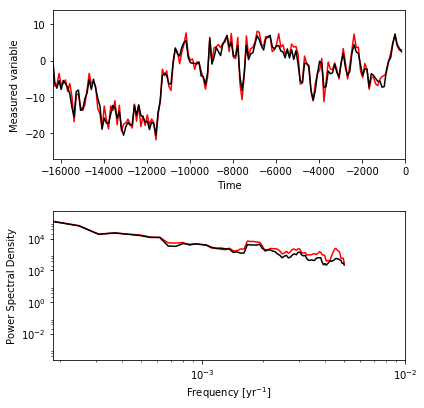

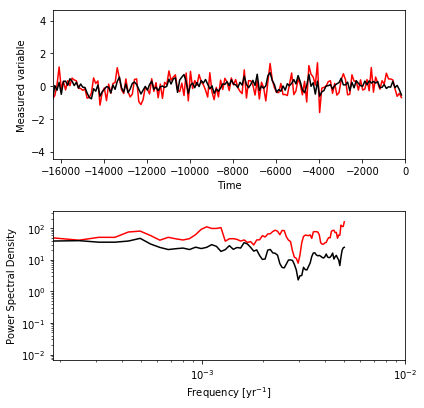

In [8]:
# Plot several cases of artificial noise

RL = 2**14
taus = 100

beta = 1.5
taub = 10
plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

#beta = 1.
#taub = 40
#plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

beta = 0.5
taub = 10
plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

#beta = 1E-16
#taub = 10
#plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')



Mean = 0.0181054250152
Std = 0.00943177332309
Mean = 0.0664072652854
Std = 0.0320188238575


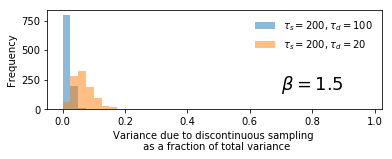

Mean = 0.0868456683975
Std = 0.0267473957754
Mean = 0.305163180098
Std = 0.0747214957243


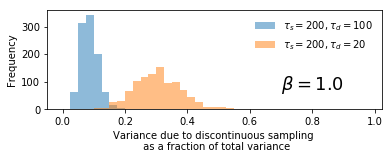

Mean = 0.244410823656
Std = 0.0483429894311
Mean = 0.678988945691
Std = 0.086111317044


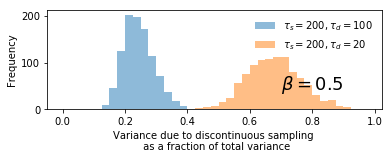

Mean = 0.500948541731
Std = 0.0805397011139
Mean = 0.904151845553
Std = 0.0650884634635


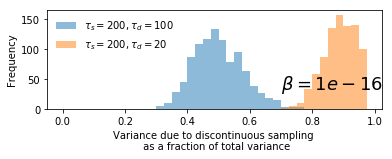

In [10]:
# Script to plot several histograms

RL = 2**14
taus = 200
N = 1000

fig5 = plt.figure()
beta = 1.5
taub1 = 100
taub2 = 20
plot_hists(RL,beta,taus,taub1,taub2,N)
#fig5.savefig('Figs/hist15.pdf', bbox_inches='tight')

beta = 1.
taub1 = 100
taub2 = 20
plot_hists(RL,beta,taus,taub1,taub2,N)

beta = 0.5
taub1 = 100
taub2 = 20
plot_hists(RL,beta,taus,taub1,taub2,N)


beta = 1E-16
taub1 = 100
taub2 = 20
plot_hists(RL,beta,taus,taub1,taub2,N)



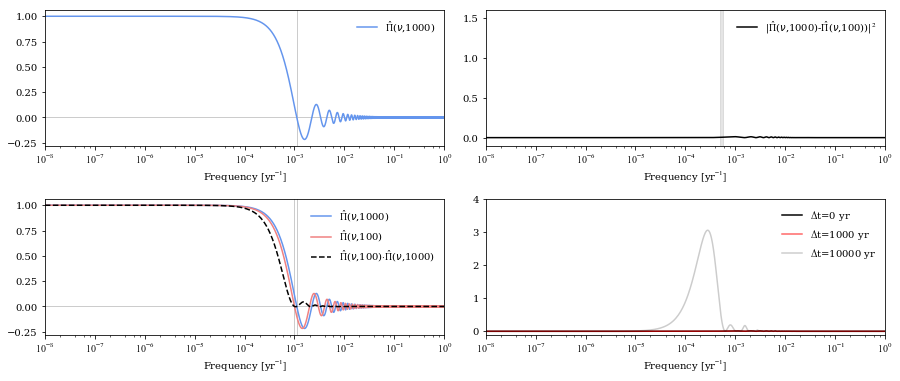

In [7]:
# Plot squares of sincs and their differences

fig4 = plt.figure(figsize=(1.4*9,.6*9))
#plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
    
#freq = np.arange(5.e-5,10.e-1,4.e-6)
freq = np.arange(1.e-8,10.e-1,4.e-6)

t1 = 1000.
t2 = 900.

ax1 = fig4.add_subplot(2, 2, 1)
#plt.axvline(x=1/t2,color='cornflowerblue',linestyle='--')
ax1.set_xscale('log')
#ax1.xaxis.set_ticks([1e-4,1e-3,1/t2,1e-2,1e-1,1])
#ax1.xaxis.set_ticklabels(['10^-4','10^{-3}','1/200','10^{-2}','10^{-1}','10^{-0}'],)
ax1.set_xlabel("Frequency [yr$^{-1}]$")
ax1.plot(freq,np.sinc(t2*freq),color='cornflowerblue')
plt.axhline(y=0,color='0.8', linestyle='-', linewidth=1,zorder=1)
plt.axvline(x=1/t2,color='0.8', linestyle='-', linewidth=1,zorder=1)
#ax1.grid(color='0.9', linestyle='-', linewidth=1)
ax1.set_xlim(np.min(freq),np.max(freq))
#ax1.set_ylim(-.1,1.6)
ax1.legend([r'$\hat{\Pi}$($\nu$,1000)'],frameon=False)

ax2 = fig4.add_subplot(2, 2, 3)
ax2.plot(freq,np.sinc(t2*freq),color='cornflowerblue',alpha=1)
ax2.plot(freq,np.sinc(t1*freq),color='lightcoral',alpha=1)
ax2.plot(freq,np.sinc(t2*freq)*np.sinc(t1*freq),color='black',linestyle='--')
ax2.set_xscale('log')
plt.axhline(y=0,color='0.8', linestyle='-', linewidth=1,zorder=1)
plt.axvline(x=1/t2,color='0.8', linestyle='-', linewidth=1,zorder=1)
plt.axvline(x=1/t1,color='0.8', linestyle='-', linewidth=1,zorder=1)
ax2.set_xlabel("Frequency [yr$^{-1}]$")
ax2.set_xlim(np.min(freq),np.max(freq))
#ax2.set_ylim(-.1,1.6)
ax2.legend([r'$\hat{\Pi}$($\nu$,1000)',r'$\hat{\Pi}$($\nu$,100)',r'$\hat{\Pi}$($\nu$,100)$\cdot$$\hat{\Pi}$($\nu$,1000)'],frameon=False)

ax3 = fig4.add_subplot(2, 2, 2)
plt.axvspan(1/(2*t2), 1/(2*t1), color='grey', alpha=0.2)
ax3.plot(freq,(-np.sinc(t2*freq)+np.sinc(t1*freq))**2,color='black',alpha=1)
ax3.set_xscale('log')
ax3.set_xlabel("Frequency [yr$^{-1}]$")
ax3.set_xlim(np.min(freq),np.max(freq))
ax3.set_ylim(-.1,1.6)
ax3.legend([r'|$\hat{\Pi}$($\nu$,1000)-$\hat{\Pi}$($\nu$,100))|$^2$'],frameon=False)

ax4 = fig4.add_subplot(2, 2, 4)
#ax4.plot(freq,2-2*np.cos(freq*100),color='black',alpha=1)
ax4.plot(freq,(-np.sinc(t2*freq)+np.sinc(t1*freq))**2,color='black',alpha=1)
ax4.plot(freq,(np.abs(np.sinc(t2*freq)-np.exp(-1j*freq*100)*np.sinc(t1*freq)))**2,color='red',alpha=.6)
ax4.plot(freq,(np.abs(np.sinc(t2*freq)-np.exp(-1j*freq*10000)*np.sinc(t1*freq)))**2,color='black',alpha=.2)
ax4.set_xscale('log')
ax4.set_xlabel("Frequency [yr$^{-1}]$")
ax4.set_xlim(np.min(freq),np.max(freq))
ax4.set_ylim(-.1,4.0)
ax4.legend([r'$\Delta$t=0 yr',r'$\Delta$t=1000 yr',r'$\Delta$t=10000 yr'],frameon=False)

fig4.tight_layout()
plt.show()

fig4.savefig('Figs/sincs.pdf', bbox_inches='tight')






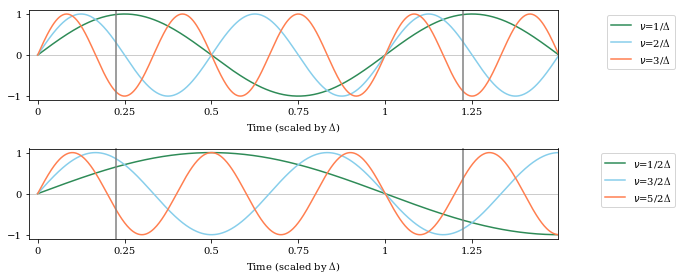

In [276]:
# Plot some cosine functions to illustrate phase lag errors

time = np.arange(0,600,1)
DEL = 400.
freq_min = np.array([1./DEL,2./DEL,3./DEL])
freq_max = np.array([1./(2*DEL),3./(2*DEL),5./(2*DEL)])
ob1 = 90.
ob2 = ob1+DEL

fig4 = plt.figure(figsize=(8,4))
#plt.rcParams["axes.grid.axis"] ="x"
plt.rcParams["axes.grid"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.rm"] = "Times New Roman"
    
ax1 = fig4.add_subplot(2, 1, 1)
ax1.set_xlabel("Time (scaled by $\Delta$)")
ax1.plot(time,np.sin(2*np.pi*time*freq_min[0]),color='seagreen')
ax1.plot(time,np.sin(2*np.pi*time*freq_min[1]),color='skyblue')
ax1.plot(time,np.sin(2*np.pi*time*freq_min[2]),color='coral')
plt.axvline(ob1,color='grey', alpha=1)
plt.axvline(ob2,color='grey', alpha=1)
plt.axhline(y=0,color='0.8', linestyle='-', linewidth=1,zorder=1)
ax1.legend([r'$\nu$=1/$\Delta$',r'$\nu$=2/$\Delta$',r'$\nu$=3/$\Delta$'],bbox_to_anchor=(.01, .9, 1.22, .102))
ax1.set_xlim([-10,max(time)])
ax1.xaxis.set_ticklabels(['','0','0.25','0.5','0.75','1','1.25','1.5'])



ax2 = fig4.add_subplot(2, 1, 2)
ax2.set_xlabel("Time (scaled by $\Delta$)")
ax2.plot(time,np.sin(2*np.pi*time*freq_max[0]),color='seagreen')
ax2.plot(time,np.sin(2*np.pi*time*freq_max[1]),color='skyblue')
ax2.plot(time,np.sin(2*np.pi*time*freq_max[2]),color='coral')
ax2.legend([r'$\nu$=1/2$\Delta$',r'$\nu$=3/2$\Delta$',r'$\nu$=5/2$\Delta$'],bbox_to_anchor=(.01, .9, 1.22, .102))
plt.axvline(ob1,color='grey', alpha=1)
plt.axvline(ob2,color='grey', alpha=1)
plt.axhline(y=0,color='0.8', linestyle='-', linewidth=1,zorder=1)
ax2.xaxis.set_ticklabels(['','0','0.25','0.5','0.75','1','1.25','1.5'])
ax2.set_xlim([-10,max(time)])

fig4.tight_layout()
plt.show()

fig4.savefig('Figs/cosines1.pdf', bbox_inches='tight')


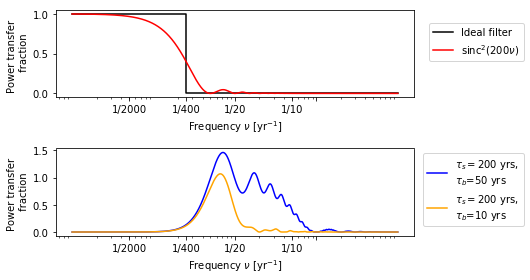

In [142]:
# Plot squares of sincs and their differences

fig4 = plt.figure()

t1 = 50.
t2 = 200.
t3 = 10.

freq = np.arange(10.e-5,10.e-1,4.e-6)

ax1 = fig4.add_subplot(2, 1, 1)
ax1.step([min(freq),1./(2*t2),max(freq)],[1.,1.,0.],color='black')
ax1.plot(freq,np.sinc(t2*freq)**2,
         color='red')

ax1.set_xscale('log')
ax1.xaxis.set_ticks([1/(2*t2)])
#ax1.xaxis.set_ticks([1/(2*t1),1/(2*t2),1/(2*t3)])
#ax1.xaxis.set_ticklabels(['1/10','1/400','1/20'])
ax1.xaxis.set_ticks([1/2000.,1/(2*t2),1/(2*t1),1/(2*t3),1/10.])
ax1.xaxis.set_ticklabels(['1/2000','1/400','1/20','1/10'])
#ax1.xaxis.set_ticklabels([r'1/400'])
#ax1.set_ylabel(r'sinc$(\tau)^2$');
ax1.set_ylabel('Power transfer \n fraction');
ax1.set_xlabel(r"Frequency $\nu$ [yr$^{-1}]$")
ax1.legend(['Ideal filter',r'sinc$^2$(200$\nu$)'],bbox_to_anchor=(.1, .8, 1.22, .102))
#ax1.set_xlim([0,2/t1])


ax2 = fig4.add_subplot(2, 1, 2)
fig4.subplots_adjust(hspace=.7);
ax2.plot(freq,(np.sinc(t3*freq)-np.sinc(t2*freq))**2,
         color='blue')
ax2.plot(freq,(np.sinc(t1*freq)-np.sinc(t2*freq))**2,
         color='orange')

ax2.set_xscale('log')
ax2.xaxis.set_ticks([1/2000.,1/(2*t2),1/(2*t1),1/(2*t3),1/10.])
ax2.xaxis.set_ticklabels(['1/2000','1/400','1/20','1/10'])
#ax2.set_ylabel(r'$($sinc$(\tau_s)$-sinc$(\tau_b))^2$');
ax2.set_ylabel('Power transfer \n fraction');
ax2.set_xlabel(r"Frequency $\nu$ [yr$^{-1}]$")
ax2.legend([r'$\tau_s=$200 yrs, ' '\n' r'$\tau_b$=50 yrs',r'$\tau_s=$200 yrs, ' '\n' r'$\tau_b$=10 yrs'],bbox_to_anchor=(.1, .9, 1.22, .102))

fig4.tight_layout()
plt.show()

fig4.savefig('Figs/sincs.pdf', bbox_inches='tight')




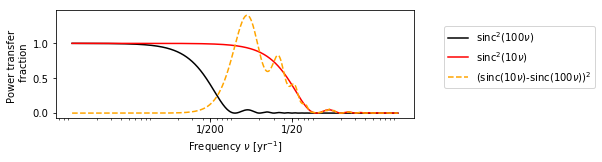

In [12]:
# Plot squares of sincs and their differences

fig4 = plt.figure()

t1 = 10.
t2 = 100.

freq = np.arange(10.e-5,10.e-1,4.e-6)

ax1 = fig4.add_subplot(2, 1, 1)
#ax1.step([min(freq),1./(2*t2),max(freq)],[1.,1.,0.],color='green')
ax1.plot(freq,np.sinc(t2*freq)**2,
         color='black')
ax1.plot(freq,np.sinc(t1*freq)**2,
         color='red')
ax1.plot(freq,(np.sinc(t1*freq)-np.sinc(t2*freq))**2,
         color='orange',ls='--')

ax1.set_xscale('log')
ax1.xaxis.set_ticks([1/(2*t2)])
ax1.xaxis.set_ticks([1/(2*t2),1/(2*t1)])
ax1.xaxis.set_ticklabels(['1/200','1/20'])
ax1.set_ylabel('Power transfer \n fraction');
ax1.set_xlabel(r"Frequency $\nu$ [yr$^{-1}]$")
#ax1.legend(['Ideal filter',r'sinc$^2$(100$\nu$)',r'sinc$^2$(10$\nu$)',r'(sinc(10$\nu$)-sinc(100$\nu$))$^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))
ax1.legend([r'sinc$^2$(100$\nu$)',r'sinc$^2$(10$\nu$)',r'(sinc(10$\nu$)-sinc(100$\nu$))$^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))

fig4.tight_layout()
plt.show()

fig4.savefig('Figs/sincs_no_ideal.pdf', bbox_inches='tight')




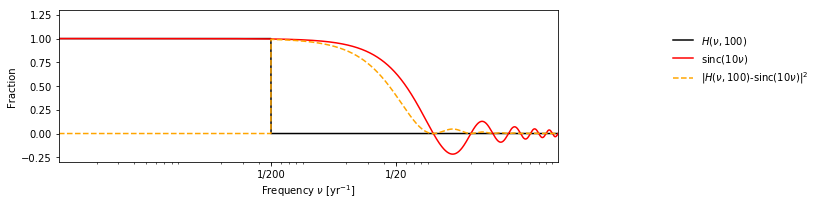

In [13]:
# Plot squares of sincs and their differences

t1 = 10.
t2 = 100.

freq = np.arange(10.e-5,10.e-1,4.e-6)

fig4 = plt.figure(figsize=(8,8))
ax1 = fig4.add_subplot(3, 1, 1)
#ax1.step([min(freq),1./(2*t2),max(freq)],[1.,1.,0.],color='black')
ax1.plot(freq,np.double(freq<1/(2*t2)),
         color='black')
ax1.plot(freq,np.sinc(t1*freq),
         color='red')
ax1.plot(freq,(np.sinc(t1*freq)-np.double(freq<1/(2*t2)))**2,
         color='orange',ls='--')

ax1.set_xscale('log')
ax1.xaxis.set_ticks([1/(2*t2)])
ax1.xaxis.set_ticks([1/(2*t2),1/(2*t1)])
ax1.xaxis.set_ticklabels(['1/200','1/20'])
ax1.set_ylabel('Fraction');
ax1.set_xlabel(r"Frequency $\nu$ [yr$^{-1}]$")
#ax1.legend(['Ideal filter',r'sinc$^2$(100$\nu$)',r'sinc$^2$(10$\nu$)',r'(sinc(10$\nu$)-sinc(100$\nu$))$^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))
#ax1.legend([r'$H(\nu,100$$)$',r'sinc(10$\nu$)',r'|$H(\nu,100)$-sinc$(10\nu)|^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))
ax1.legend([r'$H(\nu,100$$)$',r'sinc(10$\nu$)',r'|$H(\nu,100)$-sinc$(10\nu)|^2$'],bbox_to_anchor=(.1, .8, 1.42, .102),frameon=False)

fig4.tight_layout()
plt.autoscale(enable=True, tight=True)
ax1.set_ylim(-.3,1.3)
plt.show()
fig4.savefig('Figs/sincs_idea_diff.pdf', bbox_inches='tight')




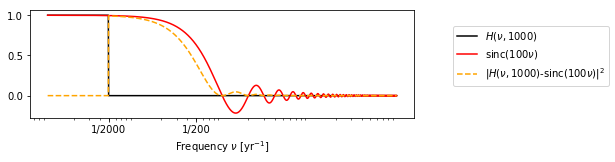

In [14]:
# Plot squares of sincs and their differences

fig4 = plt.figure()

t1 = 100.
t2 = 1000.

freq = np.arange(10.e-5,10.e-1,4.e-6)

ax1 = fig4.add_subplot(2, 1, 1)
#ax1.step([min(freq),1./(2*t2),max(freq)],[1.,1.,0.],color='black')
ax1.plot(freq,np.double(freq<1/(2*t2)),
         color='black')
ax1.plot(freq,np.sinc(t1*freq),
         color='red')
ax1.plot(freq,(np.sinc(t1*freq)-np.double(freq<1/(2*t2)))**2,
         color='orange',ls='--')

ax1.set_xscale('log')
ax1.xaxis.set_ticks([1/(2*t2)])
ax1.xaxis.set_ticks([1/(2*t2),1/(2*t1)])
ax1.xaxis.set_ticklabels(['1/2000','1/200'])
#ax1.set_ylabel('Power transfer \n fraction');
ax1.set_xlabel(r"Frequency $\nu$ [yr$^{-1}]$")
#ax1.legend(['Ideal filter',r'sinc$^2$(100$\nu$)',r'sinc$^2$(10$\nu$)',r'(sinc(10$\nu$)-sinc(100$\nu$))$^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))
ax1.legend([r'$H(\nu,1000$$)$',r'sinc(100$\nu$)',r'|$H(\nu,1000)$-sinc$(100\nu)|^2$'],bbox_to_anchor=(.1, .8, 1.42, .102))

fig4.tight_layout()
plt.show()

fig4.savefig('Figs/sincs_idea_diff.pdf', bbox_inches='tight')




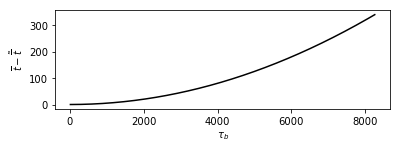

In [15]:
# Plot age model error

tau_s = np.arange(10,8270,10.)
l = 1/8267.
err = 1/l*np.log(2./(tau_s*l)*np.sinh(l*tau_s/2.))

fig5 = plt.figure()
ax1 = fig5.add_subplot(2, 1, 1)
# Plot in thousands of years.
ax1.plot(tau_s, err, color='black')
ax1.set_xlabel(r"$\tau_b$")
ax1.set_ylabel(r"$\overline{t}-\tilde{\overline{t}}$")

plt.show()

fig5.savefig('Figs/time_err.pdf', bbox_inches='tight')


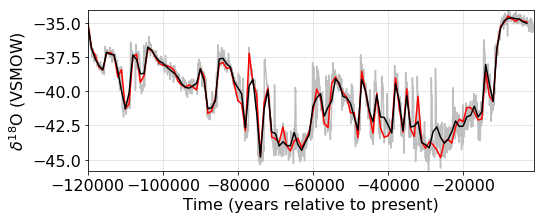

In [16]:
# NGRIP
import pandas as pd
ngrip_all = pd.read_csv('NGRIP_oxygen_isotope_50.tab',delim_whitespace=True)

# select time range
#minT = -120000
minT = -120000
maxT = -1000
ngrip_ld2 = ngrip_all[(ngrip_all['Age_[ka_BP]']<minT/-1000)&(ngrip_all['Age_[ka_BP]']>maxT/-1000)].drop_duplicates('Age_[ka_BP]').dropna()

ngrip_ld2['Age_[ka_BP]'] = ngrip_ld2['Age_[ka_BP]']*-1000

ng = ngrip_ld2.sort_values(by='Age_[ka_BP]')

# sample rate
sr = 1000.
# bin cent50
bc = np.arange(minT,maxT-sr,sr)
# short and long sample length
sl = 100.
ll = sr

# Densely sampled
binStarts = bc-ll/2
binEnds = bc+ll/2
bv, b=cts_sampler(ng['d18O_H2O'].values,ng['Age_[ka_BP]'].values,binStarts,binEnds)

# Discontinuously sampled
binStarts = bc-sl/2
binEnds = bc+sl/2
bv2, b2=cts_sampler(ng['d18O_H2O'].values,ng['Age_[ka_BP]'].values,binStarts,binEnds)

matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=.7);
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ng['Age_[ka_BP]'], ng['d18O_H2O'], color='0.75')
ax1.plot(b2,bv2, color='red')
ax1.plot(b,bv, color='black')
ax1.set_xlabel("Time (years relative to present)")
ax1.set_ylabel("$\delta^{18}$O (VSMOW)")
#ax1.legend(['Raw','50 every 200', '200 every 200'],bbox_to_anchor=(0., .7, 1.5, .102))
#ax1.legend(['NGRIP',r'$\tau_b$=1000',r'$\tau_b$=100'],bbox_to_anchor=(0., .7, 1.1, .102))
#ax2 = fig.add_subplot(2, 1, 2)
#plt.hist(bv-bv2,color='black');
#ax2.set_ylabel("Frequency")
#ax2.set_xlabel(r"Misfit between $\tau_b$ and $\tau_s$ sampling ($\delta^{18}$O VSMOW)");
#ax2.legend(['$\sigma^2$ = '+ str(round(np.var(bv-bv2),3)),'$\sigma^2_{80}$ = '+ str(round(np.var(bv-bv2),3))],bbox_to_anchor=(0., .7, 1.5, .102));
#ax2.set_xlim(-np.max(np.abs(bv-bv2)),np.max(np.abs(bv-bv2)));
ax1.grid(color='0.9', linestyle='-', linewidth=1)
plt.autoscale(enable=True, tight=True)
fig.savefig('Figs/GRIP-sampling-histo.pdf', bbox_inches='tight')

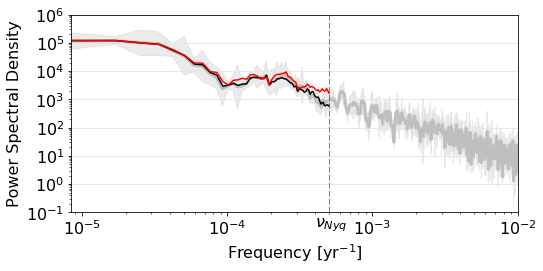

In [17]:
# Calculate the spectral estimation.plt.style.use("ggplot")
plt.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{Bitstream Vera Sans}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  

matplotlib.rcParams.update({'font.size': 16})
from mtspec import mtspec
from mtspec.util import _load_mtdata

spec, freq,jackknife,_,_= mtspec(data=ng.d18O_H2O.dropna().values,
                                 delta=50, time_bandwidth=3.5,statistics=True)
spec2, freq2,jackknife2,_,_= mtspec(data=bv,
                                 delta=sr, time_bandwidth=3.5,statistics=True)
spec3, freq3,jackknife3,_,_= mtspec(data=bv2,
                                 delta=sr, time_bandwidth=3.5,statistics=True)

## Plot
fig3 = plt.figure(figsize=(8,8))

ax1 = fig3.add_subplot(2, 1, 1)
ax1.fill_between(freq, jackknife[:, 0], jackknife[:, 1],
                 color="0.75", alpha=0.3)
ax1.plot(freq, spec, color='0.75',linewidth=3)
ax1.plot(freq2, spec2, color='black')
ax1.plot(freq3, spec3, color='red')

ax1.set_xlabel("Frequency [yr$^{-1}]$")
ax1.set_ylabel(r"Power Spectral Density")# ($(\delta^{18}$O$)^2\tau_s^{-1}$)")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.plot([1/2000.,1/2000.],[10**-1,10**6], 'k--',linewidth=0.5)
ax1.text(4E-4,3E-2,r"$\nu_{Nyq}$")
ax1.set_ylim(1E-1, 1E6)
#ax1.set_ylim(10E1, 5E5)
#ax1.set_xlim(1./120000, 2./2000)
#ax1.grid(color='0.9', linestyle='-', linewidth=1)
#ax1.legend(['NGRIP',r'$\tau_b$=1000',r'$\tau_b$=100'],bbox_to_anchor=(0., .7, 1.1, .102))
plt.autoscale(enable=True, tight=True)
ax1.grid(axis='y',color='0.9', linestyle='-', linewidth=1)
fig3.savefig('Figs/GRIP-sampling-PSD.pdf', bbox_inches='tight');
             


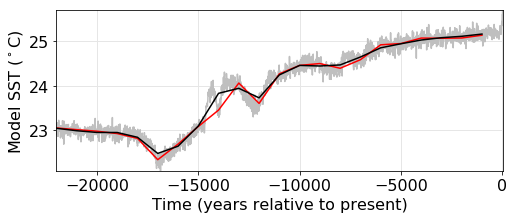

In [18]:
file='/Users/dan/Downloads/trace.01-36.22000BP.pop.TEMP.22000BP_decavg_400BCE.nc'
fh = Dataset(file, mode='r')

# Cariaco is roughly at 11 N, 65 W (335)
carlat = 11
carlon = 335

# The lat-lon grid isn't uniform, but it's close, so just use the first row / column
carlati = np.argmin(np.abs(fh.variables[u'TLAT'][:,0]-11))
carloni = np.argmin(np.abs(fh.variables[u'TLONG'][0,:]-carlon))

car = fh.variables[u'TEMP'][:,0,carlati,carloni]
time = fh.variables[u'time'][:]*1000.

# select time range
minT = np.min(time)
maxT = np.max(time)

# sample rate
sr = 1000.
# bin centers
bc = np.arange(minT,maxT-sr,sr)
# short and long sample length
sl = 100.
# Long bin length is the sample rate
ll = sr

# Densely sampled
binStarts = bc-ll/2
binEnds = bc+ll/2
bv, b=cts_sampler(car,time,binStarts,binEnds)

# Discontinuously sampled
binStarts = bc-sl/2
binEnds = bc+sl/2
bv2, b2=cts_sampler(car,time,binStarts,binEnds)

plt.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{Bitstream Vera Sans}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
matplotlib.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=.7);
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(time, car, color='0.75')
ax1.plot(b2,bv2, color='red')
ax1.plot(b,bv, color='black')
ax1.set_xlabel("Time (years relative to present)")
ax1.set_ylabel(r"Model SST ($^\circ$C)")
plt.autoscale(enable=True, tight=True)
plt.xticks([-20000,-15000,-10000,-5000,0])
ax1.grid(color='0.9', linestyle='-', linewidth=1)
plt.autoscale(enable=True, tight=True)
fig.savefig('Figs/trace_time_series.pdf', bbox_inches='tight')

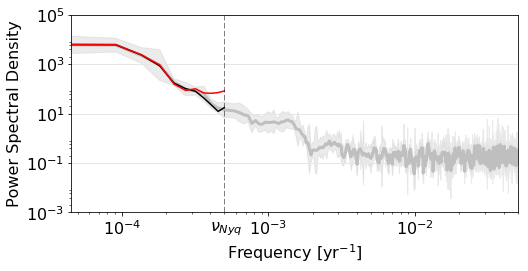

In [19]:
# Calculate the spectral estimation.plt.style.use("ggplot")
plt.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{Bitstream Vera Sans}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  

matplotlib.rcParams.update({'font.size': 16})

from mtspec import mtspec
from mtspec.util import _load_mtdata

spec, freq,jackknife,_,_= mtspec(data=car,
                                 delta=10, time_bandwidth=3.5,statistics=True)
spec2, freq2,jackknife2,_,_= mtspec(data=bv,
                                 delta=sr, time_bandwidth=3.5,statistics=True)
spec3, freq3,jackknife3,_,_= mtspec(data=bv2,
                                 delta=sr, time_bandwidth=3.5,statistics=True)

## Plot
fig3 = plt.figure(figsize=(8,8))

ax1 = fig3.add_subplot(2, 1, 1)
ax1.fill_between(freq, jackknife[:, 0], jackknife[:, 1],
                 color="0.75", alpha=0.3)
ax1.plot(freq, spec, color='0.75',linewidth=3)
ax1.plot(freq2, spec2, color='black')
ax1.plot(freq3, spec3, color='red')
ax1.plot([1/2000.,1/2000.],[10**-3,10**5], 'k--',linewidth=0.5)
ax1.text(4E-4,1.8E-4,r"$\nu_{Nyq}$")


ax1.set_xlabel("Frequency [yr$^{-1}]$")
ax1.set_ylabel(r"Power Spectral Density")# ($^\circ$C$^2\tau_s^{-1}$)")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim(1E-3, 1E5)
#ax1.set_xlim(1./120000, 2./2000)
plt.autoscale(enable=True, tight=True)
#ax1.legend(['NGRIP',r'$\tau_b$=1000',r'$\tau_b$=100'],bbox_to_anchor=(0., .7, 1.1, .102))
ax1.grid(axis='y',color='0.9', linestyle='-', linewidth=1)

fig3.savefig('Figs/trace_PSD.pdf', bbox_inches='tight');
             



Ratio from variances = 0.0238032009746
Ratio from variances = 0.640264143496


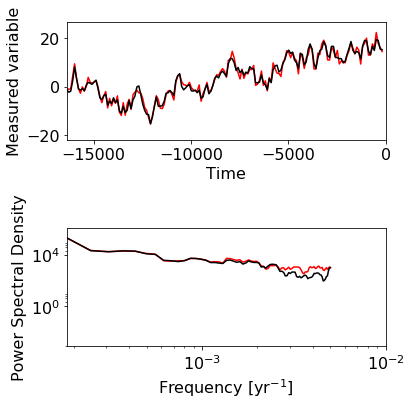

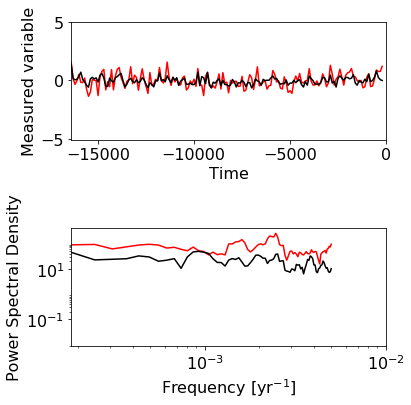

In [21]:
# Plot several cases of artificial noise

RL = 2**14
taus = 100

beta = 1.5
taub = 10
plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

#beta = 1.
#taub = 40
#plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

beta = 0.5
taub = 10
plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

#beta = 1E-16
#taub = 10
#plot_noise(RL,beta,taus,taub,'Figs/noise_ts_spec_b_' + str(beta).replace('.','')+'.pdf')

